In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,accuracy_score
from tensorflow.keras.layers import TextVectorization


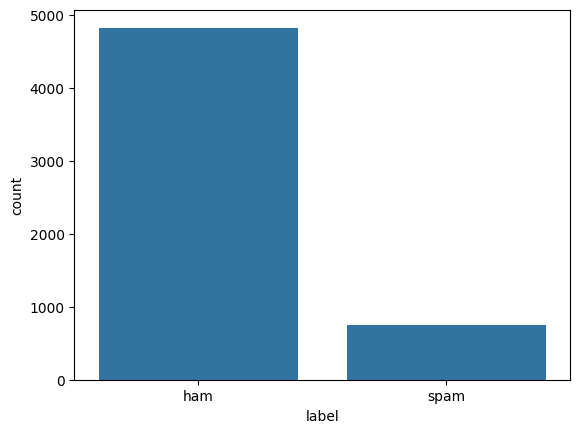

In [12]:
#Reading the data
df = pd.read_csv("E:\datasets\spam.csv",encoding='latin-1')
df.head()
df = df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
df = df.rename(columns={'v1':'label','v2':'Text'})
df['label_enc'] = df['label'].map({'ham':0,'spam':1})
df.head()
sns.countplot(x=df['label'])
plt.show()

In [13]:
X, y = np.asanyarray(df['Text']), np.asanyarray(df['label_enc'])
new_df = pd.DataFrame({'Text': X, 'label': y})
X_train, X_test, y_train, y_test = train_test_split(
    new_df['Text'], new_df['label'], test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape
tfidf_vec = TfidfVectorizer().fit(X_train)
X_train_vec,X_test_vec = tfidf_vec.transform(X_train),tfidf_vec.transform(X_test)
baseline_model = MultinomialNB()
avg_words_len=round(sum([len(i.split()) for i in df['Text']])/len(df['Text']))
s = set()
for sent in df['Text']:
 for word in sent.split():
	  s.add(word)
total_words_length=len(s)
MAX_TOKENS=total_words_length
OUTPUT_LEN=avg_words_len


In [14]:
text_vec = TextVectorization(
	max_tokens=MAX_TOKENS,
	standardize='lower_and_strip_punctuation',
	output_mode='int',
	output_sequence_length=OUTPUT_LEN
)

In [15]:
text_vec.adapt(X_train)
embedding_layer = layers.Embedding(
	input_dim=MAX_TOKENS,
	output_dim=128,
	embeddings_initializer='uniform',
	input_length=OUTPUT_LEN
)

In [16]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
x = layers.GlobalAveragePooling1D()(embedding_layer_model)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_1 = keras.Model(input_layer, output_layer)

In [17]:
model_1.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(
	label_smoothing=0.5), metrics=['accuracy'])
from sklearn.metrics import precision_score, recall_score, f1_score

def compile_model(model):
	model.compile(optimizer=keras.optimizers.Adam(),
				loss=keras.losses.BinaryCrossentropy(),
				metrics=['accuracy'])

def fit_model(model, epochs, X_train=X_train, y_train=y_train,
			X_test=X_test, y_test=y_test):
	history = model.fit(X_train,
						y_train,
						epochs=epochs,
						validation_data=(X_test, y_test),
						validation_steps=int(0.2*len(X_test)))
	return history



In [18]:
def evaluate_model(model, X, y):
	y_preds = np.round(model.predict(X))
	accuracy = accuracy_score(y, y_preds)
	precision = precision_score(y, y_preds)
	recall = recall_score(y, y_preds)
	f1 = f1_score(y, y_preds)

	model_results_dict = {'accuracy': accuracy,
						'precision': precision,
						'recall': recall,
						'f1-score': f1}
	return model_results_dict


In [ ]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
bi_lstm = layers.Bidirectional(layers.LSTM(
	64, activation='tanh', return_sequences=True))(embedding_layer_model)
lstm = layers.Bidirectional(layers.LSTM(64))(bi_lstm)
flatten = layers.Flatten()(lstm)
dropout = layers.Dropout(.1)(flatten)
x = layers.Dense(32, activation='relu')(dropout)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_2 = keras.Model(input_layer, output_layer)

compile_model(model_2) # compile the model
history_2 = fit_model(model_2, epochs=10)